In [1]:
import pandas as pd
import numpy as np
import warnings
import math
import statistics
import Floors
import Leases
import Currency
import Label 
import ModelPrep_Alternate
import CompanySize
import NYSE

warnings.simplefilter('ignore')

In [2]:
# TishmanTenants, YahooData = NYSE.processing()

In [3]:
# TishmanTenants.to_csv('Tenants_with_NYSECode_and_YahooData.csv')
# YahooData.to_csv('YahooData.csv')

In [4]:
TishmanTenants = pd.read_csv('Tenants_with_NYSECode_and_YahooData.csv')

In [5]:
#initialize lease data that is already joined with long/lat data
leases = Leases.create()

#Floors conversion
leases = Floors.processing(leases)

#Currency conversion
leases = Currency.processing(leases)

#Label/Target Creation
leases = Label.processing(leases)

# create csv for tenants for financial information gathering
#leases.Tenant.drop_duplicates().to_csv('tenants_for_priceindex.csv', index = False)

#joining company size information 
#Adds 'Empoyee Count', 'Company Size'(Categorical) as features 
leases = pd.merge(leases,CompanySize.processing(),left_on = 'Tenant', right_on = 'Tenant',how='left')

0.0 % Complete
0.07785563341118897 % Complete
0.15571126682237793 % Complete
0.2335669002335669 % Complete
0.31142253364475586 % Complete
0.3892781670559448 % Complete
0.4671338004671338 % Complete
0.5449894338783228 % Complete
0.6228450672895117 % Complete
0.7007007007007007 % Complete
0.7785563341118896 % Complete
0.8564119675230787 % Complete
0.9342676009342676 % Complete


In [6]:
#joining NYSE Financial Information
#Adds specified Month stock prices & NYSE Code as features
leases = NYSE.preprocessing(TishmanTenants,leases)

In [7]:
modeling_data, categorical_cols, numeric_cols = ModelPrep_Alternate.processing(leases)

# Remove Correlated Columns

In [8]:
categorical_cols_analysis = pd.DataFrame(columns = ['category', 'unique_values', 'null_percent'])
categorical_cols_analysis.category = categorical_cols
categorical_cols_analysis.unique_values = categorical_cols_analysis.category.apply(lambda x: len(modeling_data[x].unique()))
# categorical_cols_analysis.has_nulls = categorical_cols_analysis.category.apply(lambda x: 1 if modeling_data[x].isnull().sum() > 0 else 0)
categorical_cols_analysis.null_percent = categorical_cols_analysis.category.apply(lambda x: modeling_data[x].isnull().sum()/modeling_data.shape[0]*100)

In [9]:
categorical_cols_analysis.round(0).sort_values(['null_percent'], ascending = False)

,category,unique_values,null_percent
0,Industry,37,0.0
1,PropertyLoc,5,0.0
30,lat_lon_y_hasnulls,2,0.0
29,lat_lon_x_hasnulls,2,0.0
28,sq_foot_percent_change_hasnulls,2,0.0
27,CompanySize,9,0.0
26,MissingFloor,2,0.0
25,address,83,0.0
24,Property,101,0.0
23,PropNumber,68,0.0


In [10]:
numeric_cols_analysis = pd.DataFrame(columns = ['category','null_percent'])
numeric_cols_analysis.category = numeric_cols
numeric_cols_analysis.null_percent = numeric_cols_analysis.category.apply(lambda x: modeling_data[x].isnull().sum()/modeling_data.shape[0]*100)

In [11]:
numeric_cols_analysis.round(0).sort_values(['null_percent'], ascending = False)

,category,null_percent
0,StartingPerSqFt_USD,0.0
16,lease_length,0.0
29,simult_months,0.0
28,simult_count,0.0
27,hist_usdSpend,0.0
26,hist_months,0.0
25,hist_count,0.0
24,lat_lon_z,0.0
23,lat_lon_y,0.0
22,lat_lon_x,0.0


In [12]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [13]:
modeling_data['AmountofFloors'].value_counts()

1     3868
3        1
14       1
Name: AmountofFloors, dtype: int64

In [14]:
from sklearn import preprocessing

corr_df = modeling_data[numeric_cols + ['ContinuedRelationship']]

numeric_cols_modeling = corr_df.columns


#which numeric columns have nans
numeric_nan_cols = [numeric_cols_modeling[i]  for i in range(len(numeric_cols_modeling))if (corr_df[numeric_cols_modeling].isnull().sum().tolist()[i] > 0)]

#replace nans with means
for col_name in numeric_nan_cols:
    #create a new column that indicates that column had nulls originally
#     new_col = col_name + '_hasnulls'
#     corr_df[new_col] = corr_df.apply(lambda x: has_nulls(x, col_name), axis=1)
    
    #add new_col to categorical_col list
#     categorical_cols_modeling.append(new_col)
    
    #replace nans in the column with the mean
    col_mean = np.nanmean(corr_df[col_name])
    corr_df[col_name] = corr_df.apply(lambda x: ModelPrep.numeric_replace_null_with_mean(x, col_name, col_mean), axis=1)

corr_df_normed = corr_df[corr_df.columns.tolist()]

for col in corr_df_normed.columns:
    normalization=preprocessing.MinMaxScaler()
#     print(corr_df_normed[col].tolist())
    corr_df_normed[col] = normalization.fit_transform(corr_df_normed[[col]])

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return sel

CORRELATION BEFORE NORMALIZED


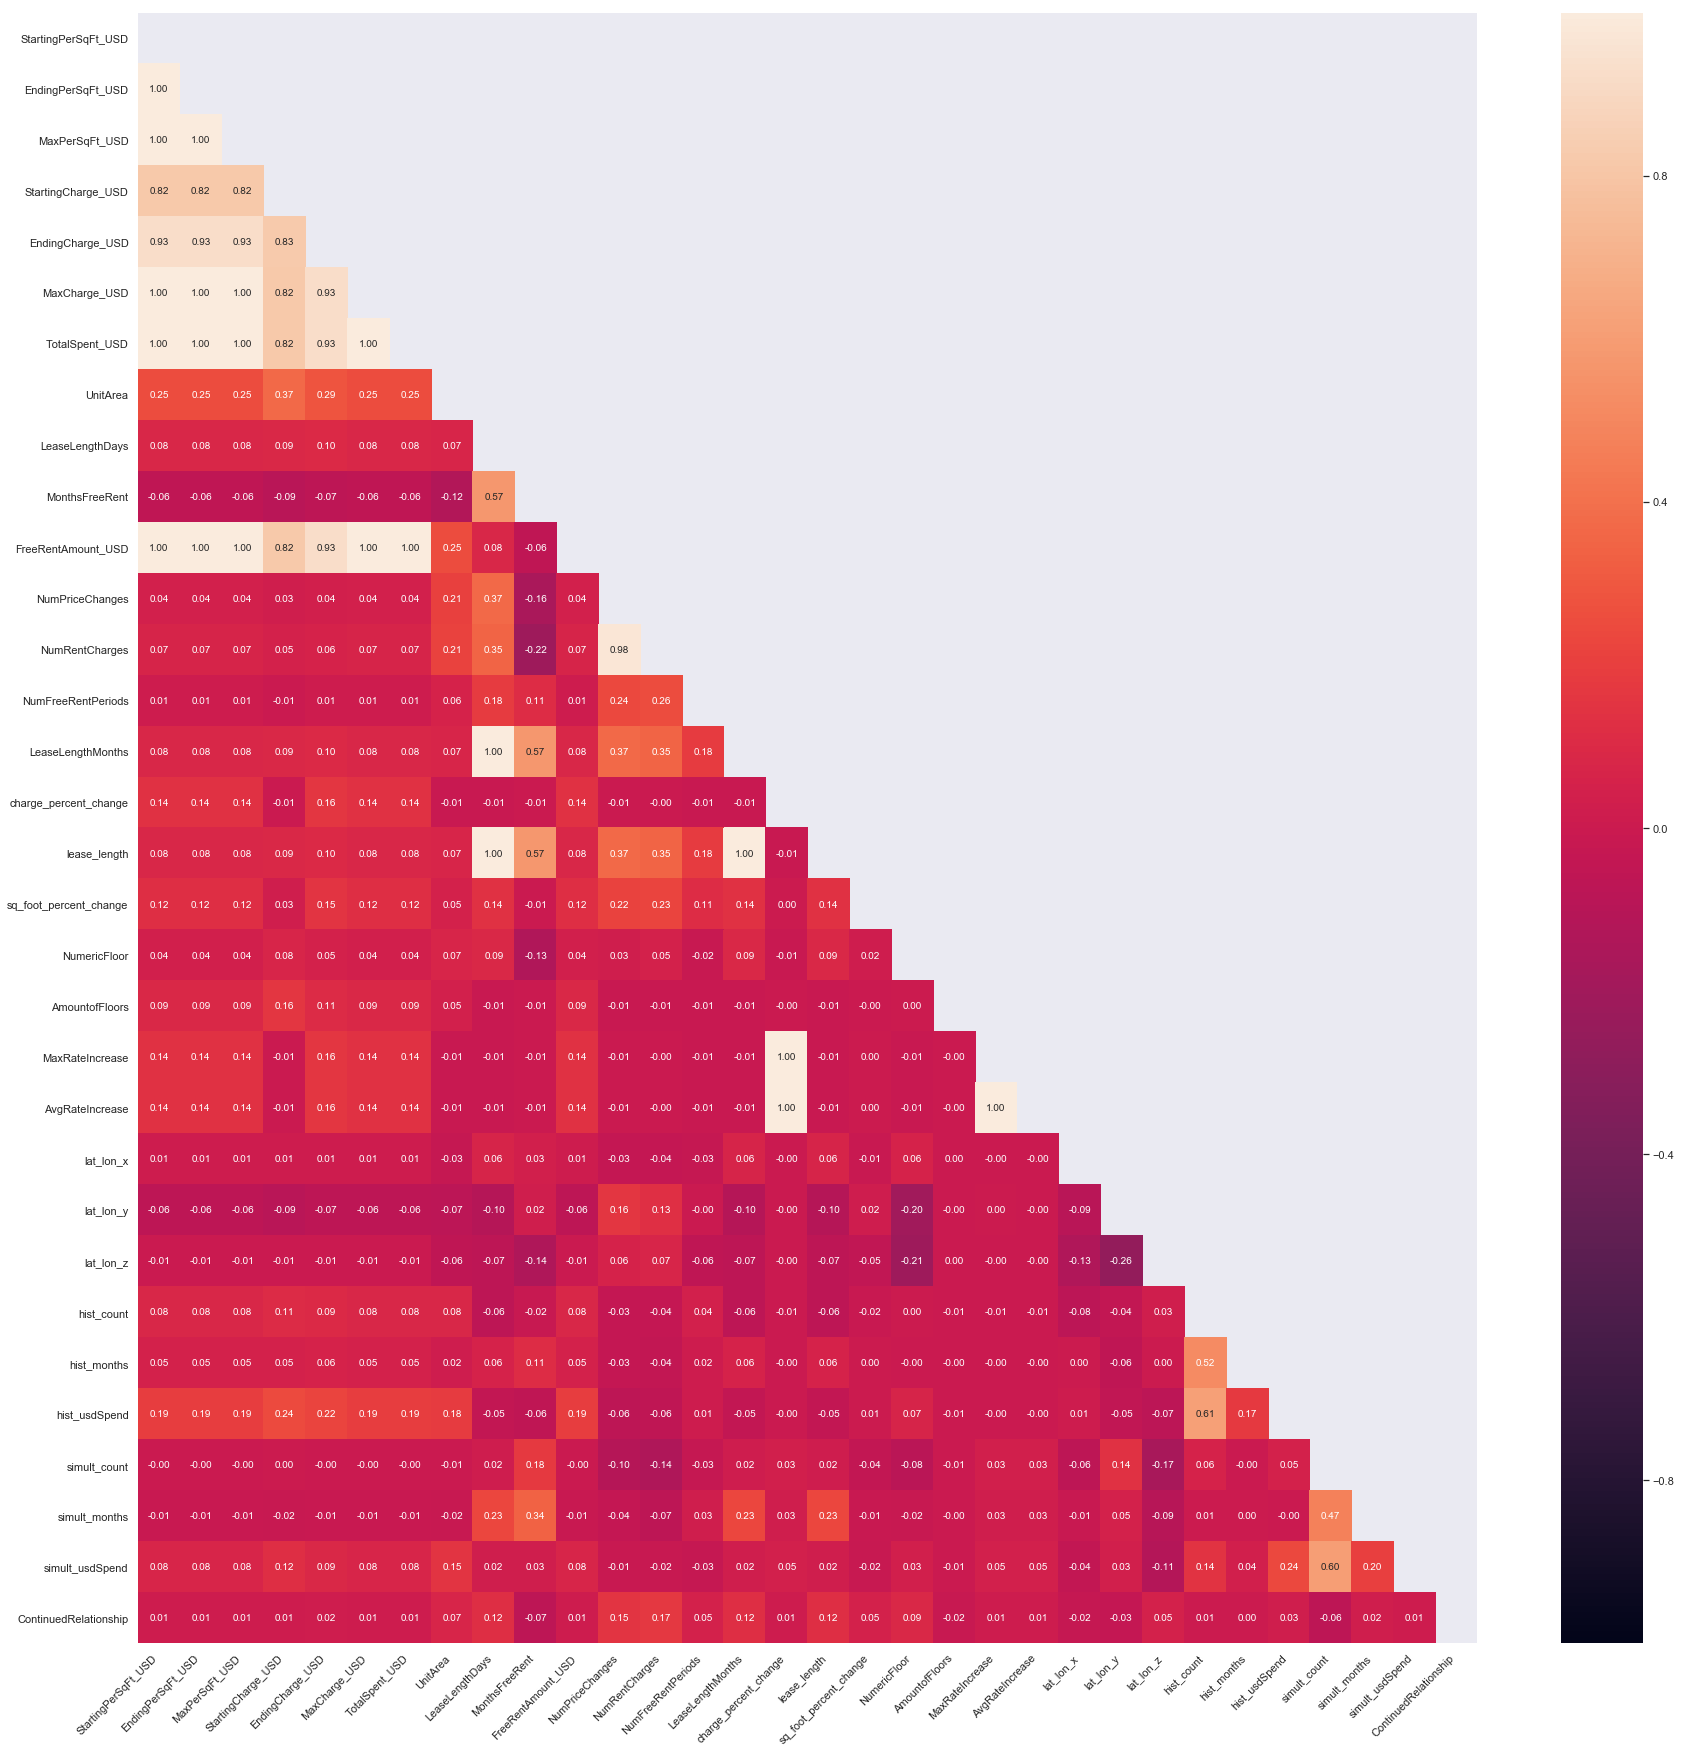

In [15]:
cor = corr_df_normed.corr()
print('CORRELATION BEFORE NORMALIZED')
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(30,30))
ax = sns.heatmap(cor, annot = True, vmin=-1, mask = mask, fmt=".2f")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [16]:
#keeping charge_percent_change, removing MaxRateIncrease, AvgRateIncrease
#keeping lease_length, removing LeaseLengthDays, LeaseLengthMonths
#keeping NumPriceChanges, removing NumRentCharges
#keeping StartingCharge_USD removing 'EndingPerSqFt_USD','MaxPerSqFt_USD','StartingCharge_USD','EndingCharge_USD','MaxCharge_USD','TotalSpent_USD','FreeRentAmount_USD'

numeric_cols_correlation_remove = ['MaxRateIncrease', 'AvgRateIncrease', 'LeaseLengthDays', 'LeaseLengthMonths', 
                                   'NumRentCharges','EndingPerSqFt_USD','MaxPerSqFt_USD','StartingCharge_USD',
                                   'EndingCharge_USD','MaxCharge_USD','TotalSpent_USD','FreeRentAmount_USD',
                                  'TenantFinanceStart', 'TenantFinanceEnd']

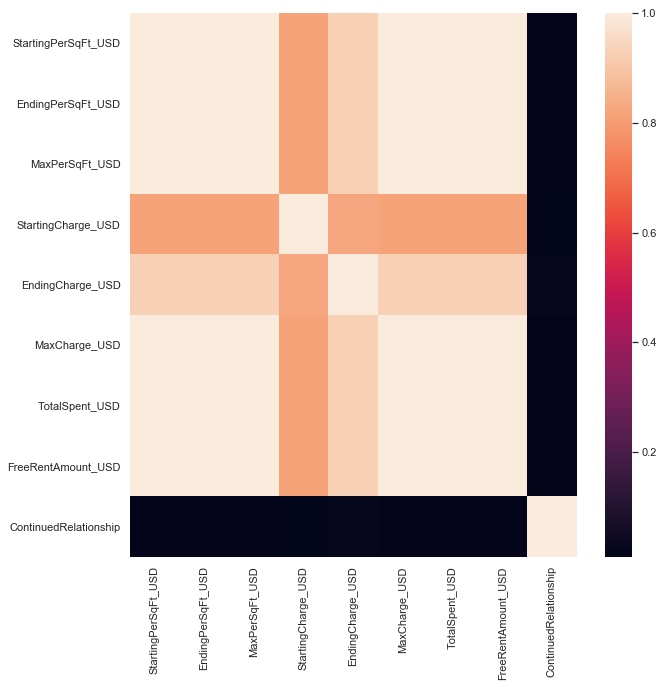

In [17]:
# Checking to see if one of the columns are more correlated than the other
USD_cols = ['StartingPerSqFt_USD','EndingPerSqFt_USD','MaxPerSqFt_USD','StartingCharge_USD','EndingCharge_USD',
            'MaxCharge_USD','TotalSpent_USD','FreeRentAmount_USD']
plt.figure(figsize=(10,10))
ax = sns.heatmap(modeling_data[USD_cols + ['ContinuedRelationship']].corr())

In [18]:
modeling_data[USD_cols + ['ContinuedRelationship']].corr()['ContinuedRelationship']

StartingPerSqFt_USD      0.013376
EndingPerSqFt_USD        0.013376
MaxPerSqFt_USD           0.013376
StartingCharge_USD       0.009048
EndingCharge_USD         0.021718
MaxCharge_USD            0.013376
TotalSpent_USD           0.013376
FreeRentAmount_USD       0.013376
ContinuedRelationship    1.000000
Name: ContinuedRelationship, dtype: float64

CORRELATION AFTER


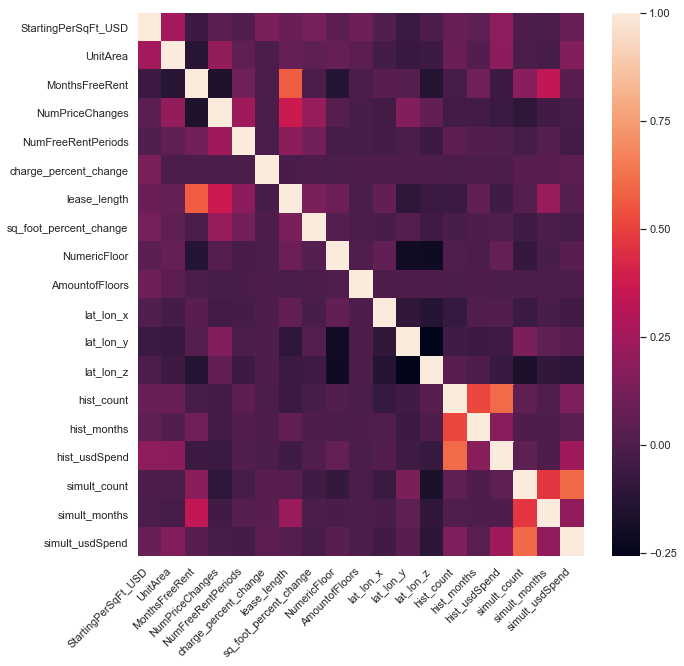

In [19]:
print('CORRELATION AFTER')
plt.figure(figsize=(10,10))
ax = sns.heatmap(modeling_data[[i for i in numeric_cols if i not in numeric_cols_correlation_remove]].corr())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

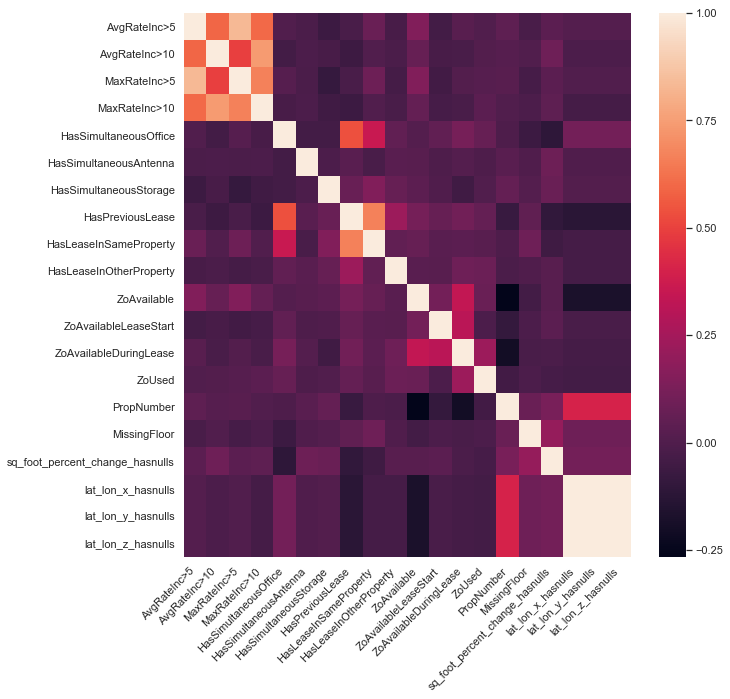

In [20]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(modeling_data[categorical_cols].corr())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [21]:
modeling_data[['AvgRateInc>5', 'MaxRateInc>5'] + ['ContinuedRelationship']].corr()['ContinuedRelationship']

AvgRateInc>5             0.097508
MaxRateInc>5             0.124354
ContinuedRelationship    1.000000
Name: ContinuedRelationship, dtype: float64

In [22]:
#keeping MaxRateInc>5 removing AvgRateInc>5
#keeping GreaterCity removing City
#keeping PropertyLoc removing Country
#keeping PropertyName removing address and PropertyNumber

categorical_cols_correlation_remove = ['AvgRateInc>5', 'City', 'Country', 'address', 'PropNumber']

In [23]:
categorical_cols_modeling = [i for i in categorical_cols if i not in categorical_cols_correlation_remove]

# which categorical columns have nans
categorical_nan_cols = [categorical_cols_modeling[i]  for i in range(len(categorical_cols_modeling))if (modeling_data[categorical_cols_modeling].isnull().sum().tolist()[i] > 0)]

#replace nans with string nans
for col_name in categorical_nan_cols:
    #create a new column that indicates that column had nulls originally
    new_col = col_name + '_hasnulls'
    modeling_data[new_col] = modeling_data.apply(lambda x: ModelPrep.has_nulls(x, col_name), axis=1)
    
    #add new_col to categorical_col list
    categorical_cols_modeling.append(new_col)
    
    #replace nans in the column with the string nan
    col_mode = 'na'
    modeling_data[col_name] = modeling_data.apply(lambda x: ModelPrep.replace_nan_with_str_nan(x, col_name), axis=1)

In [24]:
numeric_cols_modeling = [i for i in numeric_cols if i not in numeric_cols_correlation_remove]

#which numeric columns have nans
numeric_nan_cols = [numeric_cols_modeling[i]  for i in range(len(numeric_cols_modeling))if (modeling_data[numeric_cols_modeling].isnull().sum().tolist()[i] > 0)]

#replace nans with means
for col_name in numeric_nan_cols:
    #create a new column that indicates that column had nulls originally
    new_col = col_name + '_hasnulls'
    modeling_data[new_col] = modeling_data.apply(lambda x: ModelPrep.has_nulls(x, col_name), axis=1)
    
    #add new_col to categorical_col list
    categorical_cols_modeling.append(new_col)
    
    #replace nans in the column with the mean
    col_mean = np.nanmean(modeling_data[col_name])
    modeling_data[col_name] = modeling_data.apply(lambda x: ModelPrep.numeric_replace_null_with_mean(x, col_name, col_mean), axis=1)

## Neural Network - Entity Embedding 

In [25]:
#modeling_data.sort_values('ContinuedRelationship')
#target0 = len(modeling_data[modeling_data['ContinuedRelationship'] == 0].index)
#target1= len(modeling_data[modeling_data['ContinuedRelationship'] == 1].index)

y = np.array(modeling_data['ContinuedRelationship']).reshape(len(modeling_data),1)
modeling_data.drop(columns = ['ContinuedRelationship'], axis=1, inplace=True)

#modeling_data.drop(columns = columns_notusing , axis=1,inplace=True)
#columns_notusing.remove('ContinuedRelationship')
#modeling_data.drop(columns = columns_notusing , axis=1)
#y = np.array(modeling_data['ContinuedRelationship']).reshape(len(modeling_data),1)


modeling_data.head()

,Industry,PropertyLoc,City,GreaterCity,Subregion,Country,Use_Type,ConstructionType,UnitArea,UnitType,...,City_hasnulls,GreaterCity_hasnulls,Subregion_hasnulls,Country_hasnulls,Use_Type_hasnulls,ConstructionType_hasnulls,UnitType_hasnulls,PropNumber_hasnulls,Property_hasnulls,address_hasnulls
0,CONSUMER DISCRETIONARY,US-PROPERTY,NEW YORK CITY,NEW YORK CITY,"NY, NJ, CT, MA",UNITED STATES,COMMERCIAL,REDEVELOPMENT,1900.0,RETAIL,...,0,0,0,0,0,0,0,0,0,0
1,CONSUMER DISCRETIONARY,US-PROPERTY,NEW YORK CITY,NEW YORK CITY,"NY, NJ, CT, MA",UNITED STATES,COMMERCIAL,REDEVELOPMENT,1900.0,RETAIL,...,0,0,0,0,0,0,0,0,0,0
2,RETAILING,US-PROPERTY,NEW YORK CITY,NEW YORK CITY,"NY, NJ, CT, MA",UNITED STATES,COMMERCIAL,REDEVELOPMENT,895.0,RETAIL,...,0,0,0,0,0,0,0,0,0,0
3,CONSULTING,US-PROPERTY,NEW YORK CITY,NEW YORK CITY,"NY, NJ, CT, MA",UNITED STATES,COMMERCIAL,REDEVELOPMENT,4716.0,OFFICE,...,0,0,0,0,0,0,0,0,0,0
4,INDUSTRIALS,US-PROPERTY,NEW YORK CITY,NEW YORK CITY,"NY, NJ, CT, MA",UNITED STATES,COMMERCIAL,REDEVELOPMENT,9904.0,OFFICE,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#Activation Function 
def sigmoid(x,deriv=False):
    if (deriv == True): 
        return x * (1-x)
    return 1 / (1 + np.exp(-x))

learning_rate = 0.1 

In [27]:
for col in categorical_cols:
    
    X = np.array(pd.get_dummies(modeling_data[col]))
    n_categories = len(modeling_data[col].unique())

    if n_categories%2 == 0: 
        emb_dim = int((n_categories ) / 2)
    
    else: 
        emb_dim = int((n_categories + 1) /2)

    #One hidden layer neural network 

    #Weight initializiation
    w_0 = 2*np.random.random((n_categories, emb_dim)) - 1
    w_1 = 2*np.random.random((emb_dim,1)) - 1 

    for i in range(60000): 
        #forward propagation 
        output1 = np.dot(X,w_0) #1st and only hidden layer 
        output2 = sigmoid(np.dot(output1,w_1)) #output layer w. sigmoid activation
    
        #computing error 
        l2_error = y - output2
        
        #backward propagation  
        l2_delta = l2_error * sigmoid(output2, deriv = True)
        l1_error = l2_delta.dot(w_1.T)
        l1_delta = l1_error 
    
        #update weights 
        w_1 += learning_rate * output1.T.dot(l2_delta)
        w_0 += learning_rate * X.T.dot(l1_delta) 
        
    levels = np.array(pd.get_dummies(modeling_data[col]).columns)
    
    #Entity Embeddings dictionary 
    emb_dict = {}
    
    for m in range(0,w_0.shape[1]): 
        modeling_data[col+'_emb_'+str(m)] = 0
    
    for l in range(0,len(levels)): 

        emb_dict[levels[l]] = w_0[l]
        
        for m in range(0,w_0.shape[1]):
            
            #[modeling_data.index[modeling_data['ContinuedRelationship'] == 1].tolist()][0]
            
            #modeling_data[col+'_emb_'+str(m)] = w_0[l][m]
            
            modeling_data[col+'_emb_'+str(m)].iloc[[modeling_data.index[modeling_data[col] == levels[l]].tolist()][0]] = w_0[l][m]
             
    

In [28]:
modeling_data[['Industry','Industry_emb_1','Industry_emb_2','Industry_emb_3','Industry_emb_4','Industry_emb_5',
              'Industry_emb_6','Industry_emb_7','Industry_emb_8','Industry_emb_9','Industry_emb_10'
              ,'Industry_emb_11','Industry_emb_12','Industry_emb_13','Industry_emb_14','Industry_emb_15','Industry_emb_16'
              ,'Industry_emb_17','Industry_emb_18']].head(100)

,Industry,Industry_emb_1,Industry_emb_2,Industry_emb_3,Industry_emb_4,Industry_emb_5,Industry_emb_6,Industry_emb_7,Industry_emb_8,Industry_emb_9,Industry_emb_10,Industry_emb_11,Industry_emb_12,Industry_emb_13,Industry_emb_14,Industry_emb_15,Industry_emb_16,Industry_emb_17,Industry_emb_18
0,CONSUMER DISCRETIONARY,-0.569298,1.193840,-0.583425,-0.545510,-0.248692,1.099855,1.004730,-1.279083,-0.659624,-0.670995,1.060376,0.595958,0.835651,0.587604,0.865019,-0.379083,0.323290,0.239649
1,CONSUMER DISCRETIONARY,-0.569298,1.193840,-0.583425,-0.545510,-0.248692,1.099855,1.004730,-1.279083,-0.659624,-0.670995,1.060376,0.595958,0.835651,0.587604,0.865019,-0.379083,0.323290,0.239649
2,RETAILING,2.003566,-2.798579,0.052111,-0.281945,-0.291040,0.211699,-2.006160,2.325207,0.248490,-1.189472,-2.042554,0.183434,0.363841,1.800085,-0.865563,0.444380,-0.408467,-0.220228
3,CONSULTING,-5.584771,1.594684,-0.245656,0.047741,0.822221,4.107207,7.092643,-2.247361,0.418831,0.149953,7.280284,-0.804574,3.067553,-1.169887,1.389996,-6.142493,-4.459464,-1.479341
4,INDUSTRIALS,1.014225,-0.364576,0.308471,0.876201,-0.595487,0.018348,-0.613400,0.974229,-0.893792,0.640133,-0.174362,-0.431137,-0.034229,0.597654,0.245005,1.046221,1.060748,0.252312
5,DIVERSIFIED FINANCIALS,-4.909709,-2.403358,-2.969631,0.471245,2.761307,3.628783,3.997175,-1.249567,-2.203276,-2.167198,4.426354,1.027953,2.170897,-1.039873,0.369730,-4.482685,-4.500105,-4.296604
6,DIVERSIFIED FINANCIALS,-4.909709,-2.403358,-2.969631,0.471245,2.761307,3.628783,3.997175,-1.249567,-2.203276,-2.167198,4.426354,1.027953,2.170897,-1.039873,0.369730,-4.482685,-4.500105,-4.296604
7,DIVERSIFIED FINANCIALS,-4.909709,-2.403358,-2.969631,0.471245,2.761307,3.628783,3.997175,-1.249567,-2.203276,-2.167198,4.426354,1.027953,2.170897,-1.039873,0.369730,-4.482685,-4.500105,-4.296604
8,DIVERSIFIED FINANCIALS,-4.909709,-2.403358,-2.969631,0.471245,2.761307,3.628783,3.997175,-1.249567,-2.203276,-2.167198,4.426354,1.027953,2.170897,-1.039873,0.369730,-4.482685,-4.500105,-4.296604
9,RETAILING,2.003566,-2.798579,0.052111,-0.281945,-0.291040,0.211699,-2.006160,2.325207,0.248490,-1.189472,-2.042554,0.183434,0.363841,1.800085,-0.865563,0.444380,-0.408467,-0.220228


In [29]:
#Dropping no longer required Categorical cols from encoding

modeling_data.drop(columns = categorical_cols, axis=1, inplace=True)
categoricals_hasnull_emb = [ n for n in modeling_data.columns if ("_hasnulls_emb" in n)]
modeling_data.drop(columns = categoricals_hasnull_emb, axis=1, inplace=True)
modeling_data.head(100)

,UnitArea,NumPriceChanges,NumRentCharges,NumFreeRentPeriods,MonthsFreeRent,LeaseLengthDays,LeaseLengthMonths,AvgRateIncrease,MaxRateIncrease,NumericFloor,...,address_emb_38,address_emb_39,address_emb_40,address_emb_41,MissingFloor_emb_0,CompanySize_emb_0,CompanySize_emb_1,CompanySize_emb_2,CompanySize_emb_3,CompanySize_emb_4
0,1900.0,0,0,1,2.00,60.0,5.00,0.000000,0.000000,1,...,-0.192834,0.33083,0.695699,0.850615,33.376322,-0.263246,-1.018958,-5.773449,-2.027332,1.421319
1,1900.0,0,0,1,2.00,60.0,5.00,0.000000,0.000000,1,...,-0.192834,0.33083,0.695699,0.850615,33.376322,-0.263246,-1.018958,-5.773449,-2.027332,1.421319
2,895.0,0,0,1,2.00,60.0,5.00,0.000000,0.000000,1,...,-0.192834,0.33083,0.695699,0.850615,33.376322,4.962525,-8.806518,8.683100,-3.055054,-6.255442
3,4716.0,1,2,1,3.97,2682.0,223.50,8.333333,8.333333,30,...,-0.192834,0.33083,0.695699,0.850615,33.376322,4.962525,-8.806518,8.683100,-3.055054,-6.255442
4,9904.0,1,2,0,0.00,3859.0,321.58,11.499278,11.499278,8,...,-0.192834,0.33083,0.695699,0.850615,33.376322,-23.449344,21.213733,17.133623,-8.912883,-9.442948
5,37261.0,2,3,0,0.00,4121.0,343.42,10.025210,10.526322,11,...,-0.192834,0.33083,0.695699,0.850615,33.376322,-23.449344,21.213733,17.133623,-8.912883,-9.442948
6,37198.0,2,3,0,0.00,4121.0,343.42,10.025206,10.526313,12,...,-0.192834,0.33083,0.695699,0.850615,33.376322,-23.449344,21.213733,17.133623,-8.912883,-9.442948
7,36502.0,2,3,0,0.00,4221.0,351.75,10.025060,10.526313,13,...,-0.192834,0.33083,0.695699,0.850615,33.376322,-23.449344,21.213733,17.133623,-8.912883,-9.442948
8,2143.0,0,0,1,13.17,395.0,32.92,0.000000,0.000000,-1,...,-0.192834,0.33083,0.695699,0.850615,33.376322,-23.449344,21.213733,17.133623,-8.912883,-9.442948
9,37536.0,1,5,7,17.14,2191.0,182.58,2.500000,10.000000,14,...,-0.192834,0.33083,0.695699,0.850615,33.376322,-0.257777,1.108205,1.420936,0.200732,-0.469784


In [30]:
modeling_data['ContinuedRelationship'] = y
positive_indexes = [modeling_data.index[modeling_data['ContinuedRelationship'] == 1].tolist()][0]
negative_indexes = [modeling_data.index[modeling_data['ContinuedRelationship'] == 0].tolist()][0]

### PCA

In [31]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plot
%matplotlib inline

X = np.array(modeling_data)
pca = PCA(n_components=3)
#pca.fit(X)

dimension_reduction = pca.fit_transform(X)
dimension_reduction

array([[-4562250.7878195 ,  -123715.50125952,    70494.28649678],
       [-4562250.78782059,  -123715.4935454 ,    70494.27679155],
       [-4562250.78749747,  -123724.383836  ,    70497.17785911],
       ...,
       [-4562249.02844832,  -113301.20539191,    74742.29106706],
       [-4562246.46259368,   -98085.35847857,    80931.1052937 ],
       [-4562247.82072259,  -106139.48350659,    77655.02799384]])

In [32]:
dimension_reduction.shape

(3870, 3)

### PCA Plots

In [33]:
plot_x  = dimension_reduction[:,0]
plot_y  = dimension_reduction[:,1]
plot_z  = dimension_reduction[:,2]

x_values_negative = [plot_x[i] for i in negative_indexes]
x_values_positive = [plot_x[i] for i in positive_indexes]

y_values_negative = [plot_y[i] for i in negative_indexes]
y_values_positive = [plot_y[i] for i in positive_indexes]

z_values_negative = [plot_z[i] for i in negative_indexes]
z_values_positive = [plot_z[i] for i in positive_indexes]

Text(0.5, 1.0, 'PCA Dimension Reduction to 2D')

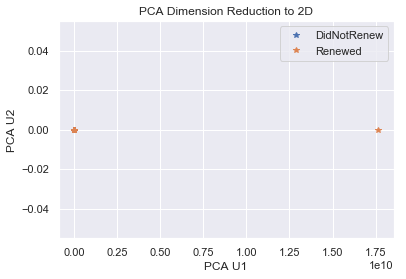

In [34]:
plot.plot(x_values_negative,np.zeros(len(x_values_negative)),'*',label='DidNotRenew')
plot.plot(x_values_positive,np.zeros(len(x_values_positive)),'*',label='Renewed')

plot.legend()

plot.xlabel('PCA U1')
plot.ylabel('PCA U2')
plot.title('PCA Dimension Reduction to 2D')

Text(0.5, 1.0, 'PCA Dimension Reduction to 2D')

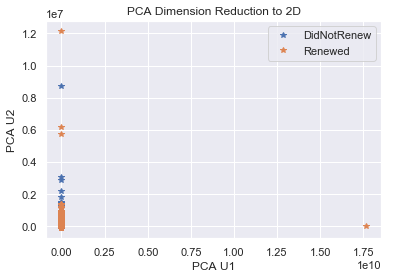

In [35]:
plot.plot(x_values_negative,y_values_negative,'*',label='DidNotRenew')
plot.plot(x_values_positive,y_values_positive,'*',label='Renewed')

plot.legend()

plot.xlabel('PCA U1')
plot.ylabel('PCA U2')
plot.title('PCA Dimension Reduction to 2D')

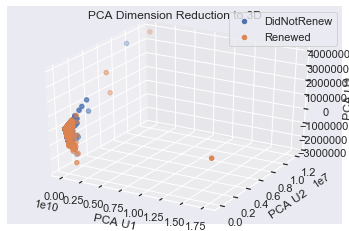

In [36]:
from mpl_toolkits.mplot3d import Axes3D
fig = plot.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=x_values_negative,ys=y_values_negative,zs=z_values_negative,zdir='z',s=20, c=None, depthshade=True,label='DidNotRenew')
ax.scatter(xs=x_values_positive,ys=y_values_positive,zs=z_values_positive,zdir='z',s=20, c=None, depthshade=True,label='Renewed')


ax.set_xlabel('PCA U1')
ax.set_ylabel('PCA U2')
ax.set_zlabel('PCA U3')
ax.set_title('PCA Dimension Reduction to 3D')
ax.legend()

### Results: Most Important Features PCA

In [37]:
for n in np.argsort(-np.absolute(pca.components_[0,:])): 
    print(modeling_data.columns[n],abs(pca.components_[0,n]))

AvgRateIncrease 0.5773502612397493
MaxRateIncrease 0.5773502609573964
charge_percent_change 0.5773502608585298
EndingCharge_USD 6.171283126826388e-05
MaxPerSqFt_USD 6.162631671450958e-05
EndingPerSqFt_USD 6.162631671450958e-05
StartingPerSqFt_USD 6.162631671450958e-05
FreeRentAmount_USD 6.162631671450958e-05
TotalSpent_USD 6.162631671450958e-05
MaxCharge_USD 6.162631671450958e-05
simult_usdSpend 4.109329016994743e-05
hist_usdSpend 4.3545354632168955e-06
StartingCharge_USD 1.5254396159864282e-06
UnitArea 3.212985666412038e-07
simult_months 2.1368431879152403e-07
LeaseLengthDays 9.634578512448394e-08
lease_length 9.634578512448394e-08
hist_months 3.79584537993959e-08
LeaseLengthMonths 8.029004124830587e-09
PropertyLoc_emb_1 5.52376021536673e-09
ZoAvailable_emb_0 2.4584821093258077e-09
PropertyLoc_emb_0 2.3196986130038634e-09
MaxRateInc>10_emb_0 2.1188238140801827e-09
MissingFloor_emb_0 1.905620467498025e-09
Subregion_emb_2 1.3727978640373023e-09
PropertyLoc_emb_2 1.0487009437402762e-09
M

### Results: Variance Explained by Principal Components v2

In [38]:
print(pca.explained_variance_ratio_[0])
print(pca.explained_variance_[0])

0.9999969791866625
8.054966974821616e+16


In [39]:
print(pca.explained_variance_ratio_[1])
print(pca.explained_variance_[1])

1.4827071879806496e-06
119431935106.73007


In [40]:
print(pca.explained_variance_ratio_[2])
print(pca.explained_variance_[2])

9.067606509397964e-07
73039491612.54854


### T-SNE

In [41]:
from sklearn.manifold import TSNE
top50_pca = PCA(n_components=50)
modeling_data_pca_reduced = top50_pca.fit_transform(X)

In [42]:
#tsne= TSNE(n_components=2)
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(modeling_data_pca_reduced)

In [43]:
plot_x  = tsne_results[:,0]
plot_y  = tsne_results[:,1]

x_values_negative = [plot_x[i] for i in negative_indexes]
x_values_positive = [plot_x[i] for i in positive_indexes]

y_values_negative = [plot_y[i] for i in negative_indexes]
y_values_positive = [plot_y[i] for i in positive_indexes]

Text(0.5, 1.0, 'T-SNE Dimension Reduction to 2D')

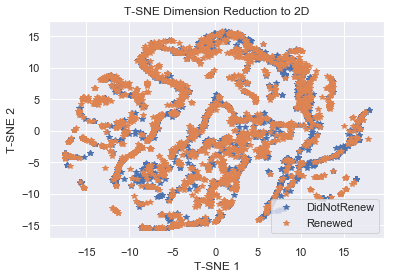

In [44]:
plot.plot(x_values_negative,y_values_negative,'*',label='DidNotRenew')
plot.plot(x_values_positive,y_values_positive,'*',label='Renewed')

plot.legend()

plot.xlabel('T-SNE 1')
plot.ylabel('T-SNE 2')
plot.title('T-SNE Dimension Reduction to 2D')

Text(0.5, 1.0, 'T-SNE Dimension Reduction to 1D')

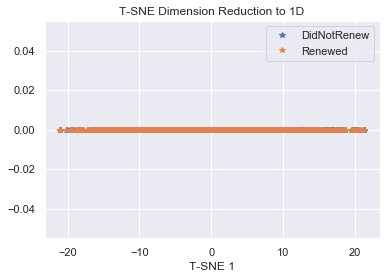

In [45]:
tsne = TSNE(n_components=1, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(modeling_data_pca_reduced)
plot_x  = tsne_results[:,0]

x_values_negative = [plot_x[i] for i in negative_indexes]
x_values_positive = [plot_x[i] for i in positive_indexes]

plot.plot(x_values_negative,np.zeros(len(x_values_negative)),'*',label='DidNotRenew')
plot.plot(x_values_positive,np.zeros(len(x_values_positive)),'*',label='Renewed')

plot.legend()

plot.xlabel('T-SNE 1')
plot.title('T-SNE Dimension Reduction to 1D')

In [46]:
pca.components_[1,:].shape

(255,)

In [47]:
len(modeling_data.columns)

255

In [48]:
6.171283126826391e-05

6.171283126826391e-05

In [49]:
0.00006171283126826391

6.171283126826391e-05